In [39]:
#|default_exp datasets

In [40]:
#|export
from __future__ import annotations
import math, numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc
from torch.utils.data import default_collate

In [5]:
import logging,pickle,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path
from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder
import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [6]:
torch.set_printoptions(precision=2, sci_mode=False, linewidth=140)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [7]:
logging.disable(logging.WARNING)

### Hugging face datasets

In [8]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [11]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [12]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [13]:
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [24]:
tuple(dsd['train'].features)

('image', 'label')

In [41]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [26]:
feat_x, label = tuple(dsd['train'].features)

In [36]:
@inplace
def transformi(b):
    b[feat_x] = [torch.flatten(TF.to_tensor(ele)) for ele in b[feat_x]]

In [37]:
tdsf = dsd['train'].with_transform(transformi)

In [38]:
r = tdsf[0]
r[feat_x].shape,r[label]

(torch.Size([784]), 9)

In [44]:
#|export
def collate_dict(ds):
    ig = itemgetter(*ds.features)
    def _f(b):
        return ig(default_collate(b))
    return _f

In [51]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))

In [54]:
xb.shape,yb.shape

(torch.Size([4, 784]), torch.Size([4]))

### Plotting images

In [489]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, noframe=True, title=None, figsize=(2,2), **kwargs):
    if fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5:
            im = im.perumte(1,2,0)
    elif not isinstance(im, np.ndarray):
        im = np.array(im)
    if im.shape[-1]==1:
        im = im[...,0]
    if ax is None:
        _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe:
        ax.axis('off')
    return ax   

In [490]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, noframe=True, title=None, figsize=(2, 2), *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    #|export



<Axes: >

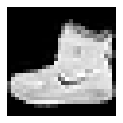

In [491]:
img = xb[0]
img = img.view(28,28,1,1)
img = img.tolist()
show_image(img, figsize=(2,2))

In [559]:
#|export
@fc.delegates(plt.subplots, keep=False)
def subplots(
    nrows:int=1,
    ncols:int=1,
    figsize:tuple=None,
    imsize:int=3,
    suptitle:str=None,
    **kwargs
):
    if figsize is None:
        figsize = (ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)
    return fig,ax

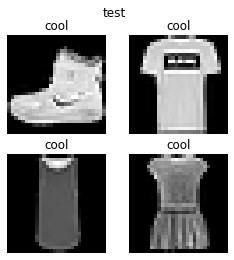

In [560]:
imgs = xb[:8]
fig,axs = subplots(2, 2, imsize=2, suptitle='test')
for ax,img in zip(axs.flat, imgs):
    show_image(img.view(28,28), ax, title='cool')

In [575]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int,
    nrows:int=None,
    ncols:int=None,
    title:str=None,
    weight:str='bold',
    size:int=14,
    **kwargs
):
    if nrows:
        ncols = ncols or int(np.floor(n/nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    return fig,axs

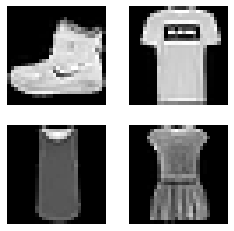

In [582]:
fig,axs = get_grid(5, imsize=2)
for ax,img in zip(axs.flat,imgs): 
    show_image(img.view(28,28), ax)

In [593]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)
     

In [597]:
#|export
@fc.delegates(subplots)
def show_images(ims:list,
                nrows:int|None=None,
                ncols:int|None=None,
                titles:list|None=None,
                **kwargs
               ):
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs):
        show_image(im, ax=ax, title=t)

In [604]:
imgs.shape
imgs = imgs.view(-1, 28, 28)
imgs.shape

torch.Size([4, 28, 28])

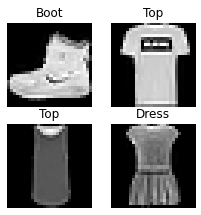

In [605]:
lbls = yb[:8]
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)
show_images(imgs, imsize=1.7, titles=titles)

In [608]:
import nbdev

In [612]:
# nbdev.nbdev_export()